In [1]:
mode = "no_train"
#mode = "train"

# Imports

In [2]:
%%capture
!pip install xarray
!pip install netcdf4

In [3]:
import os
import xarray as xr
import numpy as np
import torch
from torch.utils import data

In [4]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

In [11]:
import os
new_directory = '/dss/dsshome1/0D/ge74xuf2/climate_diffusion'
os.chdir(new_directory)
os.getcwd()

'/dss/dsshome1/0D/ge74xuf2/climate_diffusion'

In [13]:
from src.dataloaders import T_Dataset, U850_Dataset, V850_Dataset, SLP_Dataset
from src.condition_unet_loading import UNet_condition

In [15]:
from src.utils import *

In [16]:
%%capture
!pip install scikit-image

In [17]:
%%capture
from src.dataloaders import ERA5_P_Dataset
#from precipitation_preprocessing import Precipitation_Dataset

# Define Datasets

In [9]:
batch_size = 8
num_workers = 2

In [10]:
train_set_p = ERA5_P_Dataset(stage='train')
train_set_p.get_mean_std()
all_data_p = train_set_p.data()

n_val = int(len(all_data_p) * 0.1)
n_train = len(all_data_p) - n_val

train_dataset_p, val_dataset_p = random_split(all_data_p, [n_train, n_val], generator=torch.Generator().manual_seed(0))


dataloader_train_p = data.DataLoader(train_dataset_p, batch_size=batch_size, shuffle=False, drop_last=True,
                                     num_workers=num_workers)

dataloader_val_p = data.DataLoader(val_dataset_p, batch_size=100, shuffle=False, drop_last=True,
                                   num_workers=num_workers)
next(iter(dataloader_train_p)).shape

-2.346686046392396e-16 1.0000000000000002
whole era5 dataset size (6939, 64, 64)
mean: -0.260340398200719
std: 0.4902649276251692


torch.Size([8, 64, 64])

In [11]:
train_set_slp = SLP_Dataset(stage='train')
train_set_slp.get_mean_std()
all_data_slp = train_set_slp.data()


train_dataset_slp, val_dataset_slp = random_split(all_data_slp, [n_train, n_val], generator=torch.Generator().manual_seed(0))
dataloader_train_slp = data.DataLoader(train_dataset_slp, batch_size=batch_size, shuffle=False, drop_last=True,
                               num_workers=num_workers)
dataloader_val_slp = data.DataLoader(val_dataset_slp, batch_size=100, shuffle=False, drop_last=True,
                               num_workers=num_workers)
next(iter(dataloader_train_slp)).shape

self.era5.values (6939, 64, 64)
mean: 0.3719995911296485
std: 0.17212602598024812


torch.Size([8, 64, 64])

In [12]:
train_set_v850 = V850_Dataset(stage='train')
train_set_v850.get_mean_std()
all_data_v850 = train_set_v850.data()


train_dataset_v850, val_dataset_v850 = random_split(all_data_v850, [n_train, n_val], generator=torch.Generator().manual_seed(0))
dataloader_train_v850 = data.DataLoader(train_dataset_v850, batch_size=batch_size, shuffle=False, drop_last=True,
                               num_workers=num_workers)
dataloader_val_v850 = data.DataLoader(val_dataset_v850, batch_size=100, shuffle=False, drop_last=True,
                               num_workers=num_workers)
next(iter(dataloader_train_v850)).shape

self.era5.values (6939, 64, 64)
mean: -9.552709867981247e-05
std: 1.0009735788653176


torch.Size([8, 64, 64])

In [13]:
train_set_u850 = U850_Dataset(stage='train')
train_set_u850.get_mean_std()
all_data_u850 = train_set_u850.data()

train_dataset_u850, val_dataset_u850 = random_split(all_data_u850, [n_train, n_val], generator=torch.Generator().manual_seed(0))
dataloader_train_u850 = data.DataLoader(train_dataset_u850, batch_size=batch_size, shuffle=False, drop_last=True,
                               num_workers=num_workers)
dataloader_val_u850 = data.DataLoader(val_dataset_u850, batch_size=100, shuffle=False, drop_last=True,
                               num_workers=num_workers)
next(iter(dataloader_train_u850)).shape

self.era5.values (6939, 64, 64)
mean: -0.0050769219253031595
std: 0.9940078352743558


torch.Size([8, 64, 64])

# Define Unet

In [14]:
num_epoch = 100
lr = 1e-5
#mode='train'
cmap = None
device = "cuda"
valid_freq = 10
print_train = 5

In [15]:
net = UNet_condition(nch=3,nker=64,out_chan=1,norm="bnorm").to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)
fn_loss = nn.MSELoss().to(device)

In [16]:
fn_tonumpy = lambda x:x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)  # from tensor to numpy

In [17]:
if mode=='train':

    num_data_train = len(dataloader_train_p)
    num_data_val = len(dataloader_val_p)
    num_batch_train = np.ceil(num_data_train / batch_size)
    num_batch_val = np.ceil(num_data_val / batch_size)

    st_epoch = 0 # start epoch number
    num_batch_train = len(dataloader_train_p)
    
    loss_arr = []
    mean_loss_arr = []
    loss_arr_valid = []
    mean_loss_arr_valid = []

    for epoch in range(st_epoch+1, num_epoch + 1):
        #print("epoch:",epoch)
        net.train()
        

        for i, element in enumerate(zip(dataloader_train_p, dataloader_train_v850, 
                                        dataloader_train_u850, dataloader_train_slp)):
            images, cond_1, cond_2, cond_3 = element
            images = images.unsqueeze(1)
            cond_1 = cond_1.unsqueeze(1)
            cond_2 = cond_2.unsqueeze(1)
            cond_3 = cond_3.unsqueeze(1)
            
            condition = torch.cat((cond_1, cond_2, cond_3), dim=1).float().to(device)            
            label = images.float().to(device)
            output = net(condition)

            # backward pass
            optim.zero_grad()
            loss = fn_loss(output, label)
            loss.backward()
            optim.step()

            # loss function 
            loss_arr += [loss.item()]

        print("TRAIN : EPOCH %01d / %01d | LOSS %.4f" % 
                  (epoch, num_epoch, np.mean(loss_arr)))
        mean_loss_arr += [np.mean(loss_arr).item()]
                
            
        if epoch % valid_freq == 0:
            ############### validation ################
            with torch.no_grad():
                print("doing validation")
                net.eval()
                for j, element in enumerate(zip(dataloader_val_p, dataloader_val_v850, dataloader_val_u850, dataloader_val_slp)):
                    images, cond_1, cond_2, cond_3 = element
                    images = images.unsqueeze(1)
                    cond_1 = cond_1.unsqueeze(1)
                    cond_2 = cond_2.unsqueeze(1)
                    cond_3 = cond_3.unsqueeze(1)
                    
                    condition = torch.cat((cond_1, cond_2, cond_3), dim=1).float().to(device)
                    label = images.float().to(device)     
                    output = net(condition)

                    loss = fn_loss(output, label)
                    loss_arr_valid += [loss.item()]
                    
                print("VALID : EPOCH %01d / %01d | LOSS %.4f" % 
                  (epoch, num_epoch, np.mean(loss_arr_valid)))
                mean_loss_arr_valid += [np.mean(loss_arr_valid).item()]


            if epoch % 30 == 0:
                torch.save(net.state_dict(), os.path.join("models", "unet_before", f"ckpt{epoch}.pt"))

TRAIN : EPOCH 1 / 100 | LOSS 0.1157
TRAIN : EPOCH 2 / 100 | LOSS 0.0953
TRAIN : EPOCH 3 / 100 | LOSS 0.0849
TRAIN : EPOCH 4 / 100 | LOSS 0.0778
TRAIN : EPOCH 5 / 100 | LOSS 0.0725
TRAIN : EPOCH 6 / 100 | LOSS 0.0685
TRAIN : EPOCH 7 / 100 | LOSS 0.0651
TRAIN : EPOCH 8 / 100 | LOSS 0.0623
TRAIN : EPOCH 9 / 100 | LOSS 0.0598
TRAIN : EPOCH 10 / 100 | LOSS 0.0577
doing validation
VALID : EPOCH 10 / 100 | LOSS 0.0697
TRAIN : EPOCH 11 / 100 | LOSS 0.0557
TRAIN : EPOCH 12 / 100 | LOSS 0.0540
TRAIN : EPOCH 13 / 100 | LOSS 0.0524
TRAIN : EPOCH 14 / 100 | LOSS 0.0509
TRAIN : EPOCH 15 / 100 | LOSS 0.0495
TRAIN : EPOCH 16 / 100 | LOSS 0.0483
TRAIN : EPOCH 17 / 100 | LOSS 0.0472
TRAIN : EPOCH 18 / 100 | LOSS 0.0461
TRAIN : EPOCH 19 / 100 | LOSS 0.0451
TRAIN : EPOCH 20 / 100 | LOSS 0.0442
doing validation
VALID : EPOCH 20 / 100 | LOSS 0.0708
TRAIN : EPOCH 21 / 100 | LOSS 0.0433
TRAIN : EPOCH 22 / 100 | LOSS 0.0425
TRAIN : EPOCH 23 / 100 | LOSS 0.0417
TRAIN : EPOCH 24 / 100 | LOSS 0.0409
TRAIN : EPOCH

In [18]:
if mode=='train':
    print(len(loss_arr), len(dataloader_val_p)/8*30)

78000 22.5


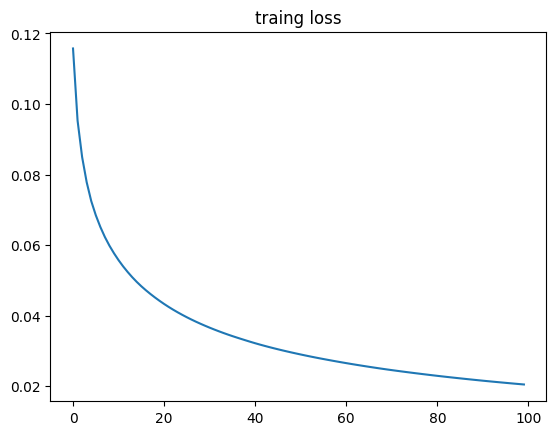

In [19]:
if mode=='train':
    plt.plot(mean_loss_arr)
    plt.title("traing loss")
    plt.show()

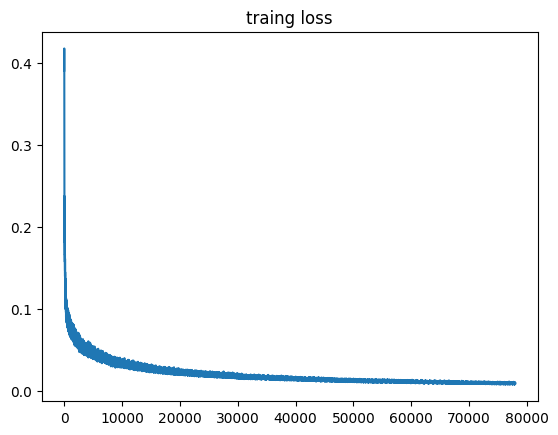

In [20]:
if mode=='train':
    plt.plot(loss_arr)
    plt.title("traing loss")
    plt.show()

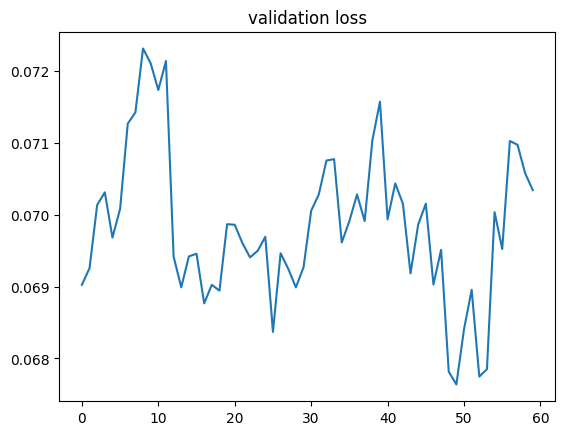

In [21]:
if mode=='train':
    plt.plot(loss_arr_valid)
    plt.title("validation loss")
    plt.show()

# load pretrained 

In [22]:
load_pretrained = True

In [23]:
if load_pretrained == True:
    loaded_model = UNet_condition(nch=3,nker=64,out_chan=1,norm="bnorm").to(device)
    state_dict = torch.load("models/unet_before/ckpt90.pt")
    loaded_model.load_state_dict(state_dict)
    
    net = loaded_model

In [24]:
for batch, element in enumerate(zip(dataloader_val_p, dataloader_val_v850, dataloader_val_u850, dataloader_val_slp)):
            images, cond_1, cond_2, cond_3 = element
            images = images.unsqueeze(1)
            cond_1 = cond_1.unsqueeze(1)
            cond_2 = cond_2.unsqueeze(1)
            cond_3 = cond_3.unsqueeze(1)
            image = torch.cat((cond_1, cond_2, cond_3), dim=1).float().to(device)
            
            label = images.float().to(device)
            output = net(image)
            
            label = fn_tonumpy(label)
            output = fn_tonumpy(output)
            
            
            if batch == 0:
                break

In [25]:
output_ = torch.from_numpy(output); output_.shape
label_ = torch.from_numpy(label); label_.shape

torch.Size([100, 64, 64, 1])

In [26]:
output_ = output_.permute(0, 3, 1, 2)
print(output_.shape)

label_ = label_.permute(0, 3, 1, 2)
print(label_.shape)

torch.Size([100, 1, 64, 64])
torch.Size([100, 1, 64, 64])


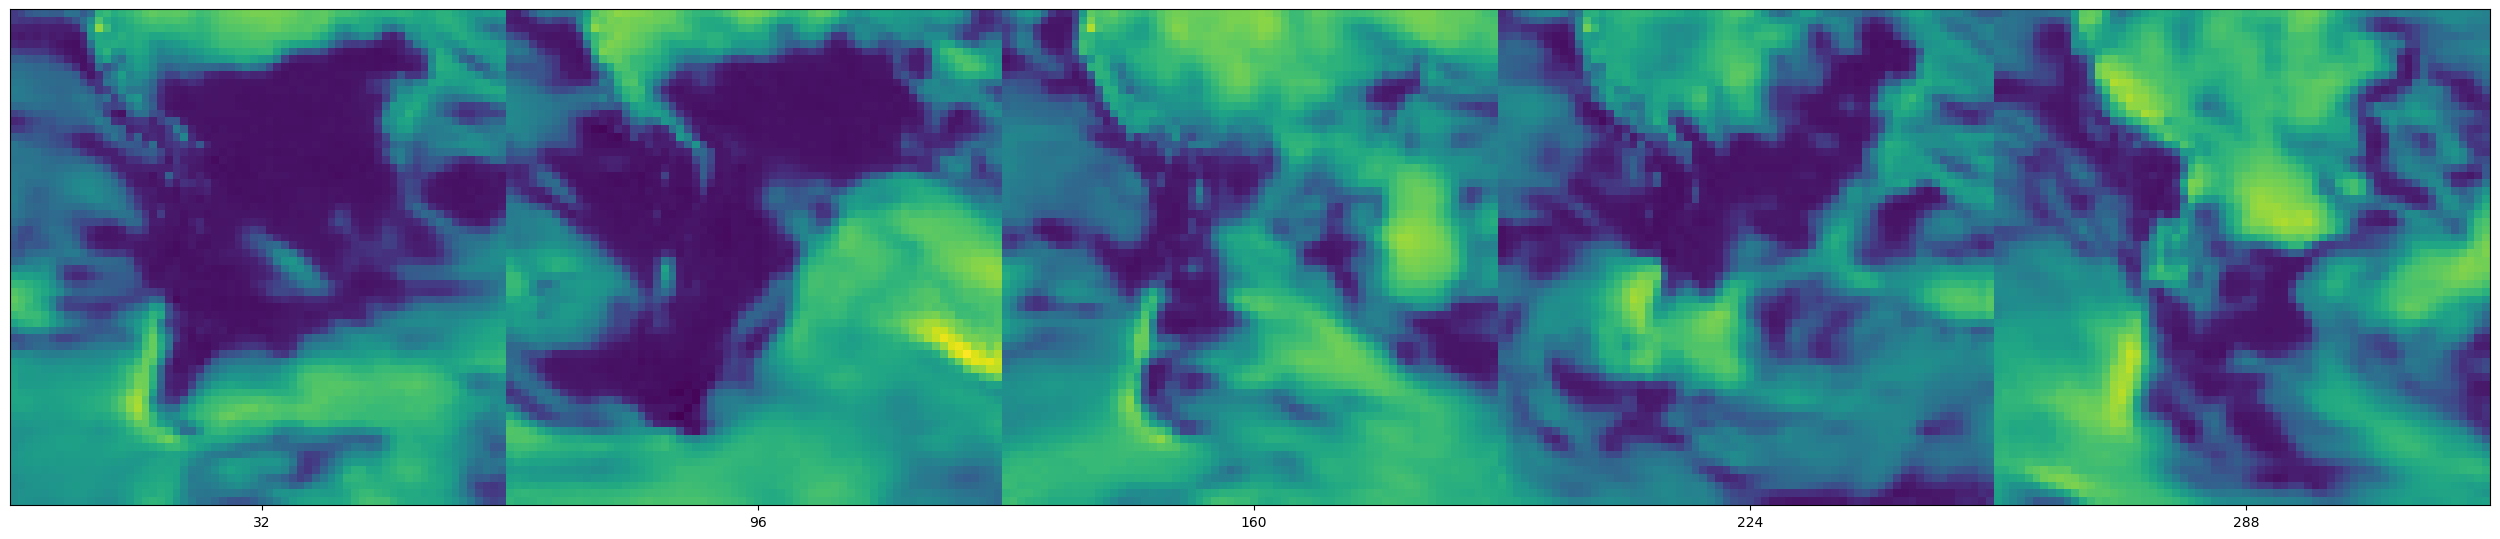

In [27]:
plot_images_no_lab(output_[:5])

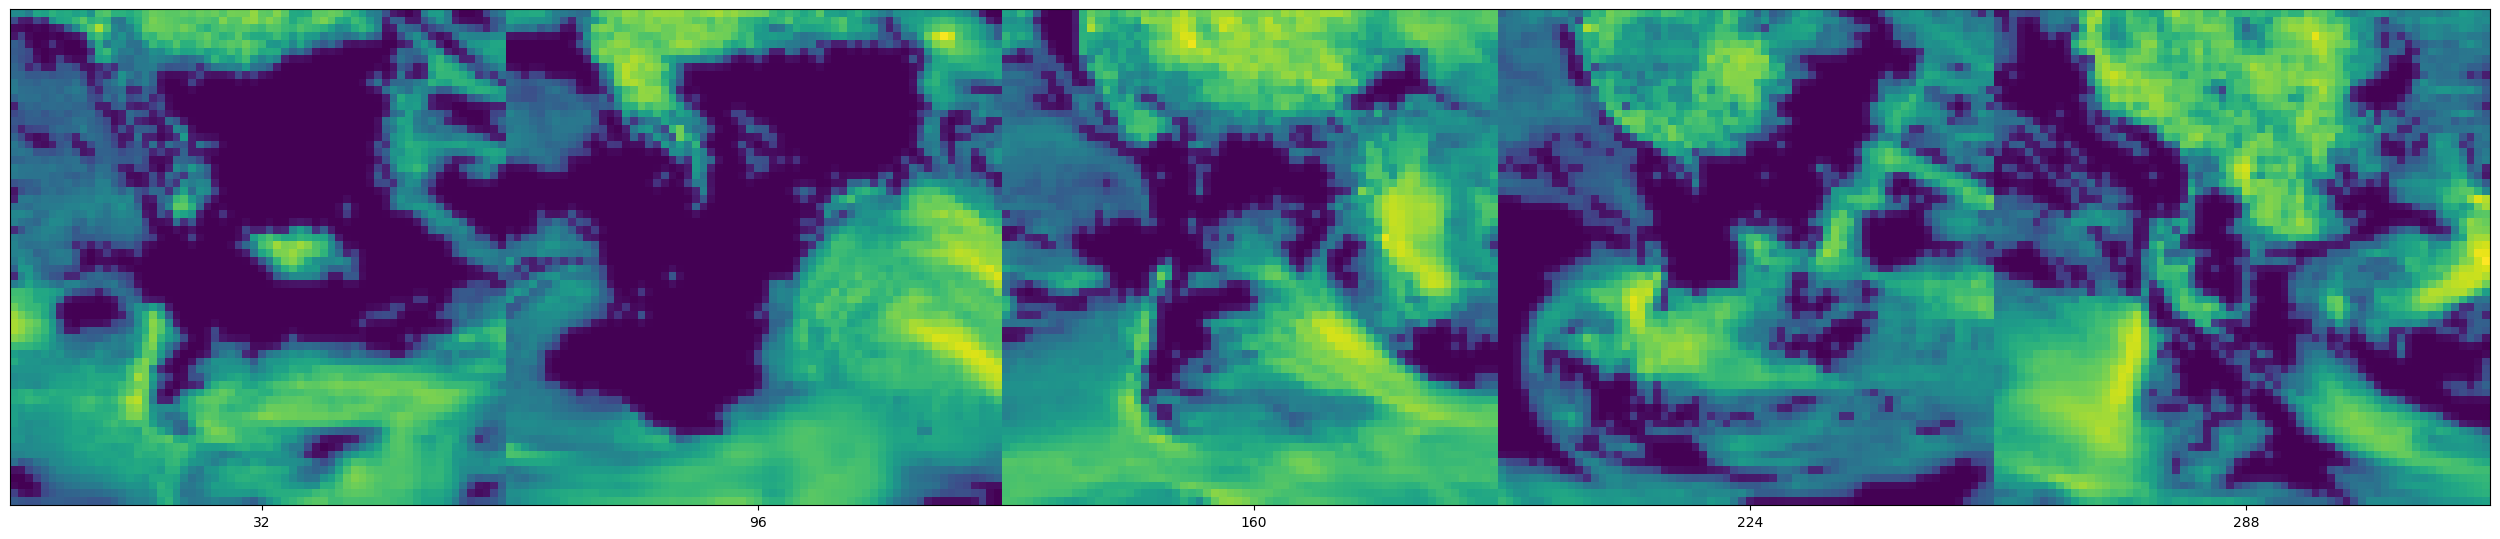

In [ ]:
plot_images_no_lab(label_[:5])

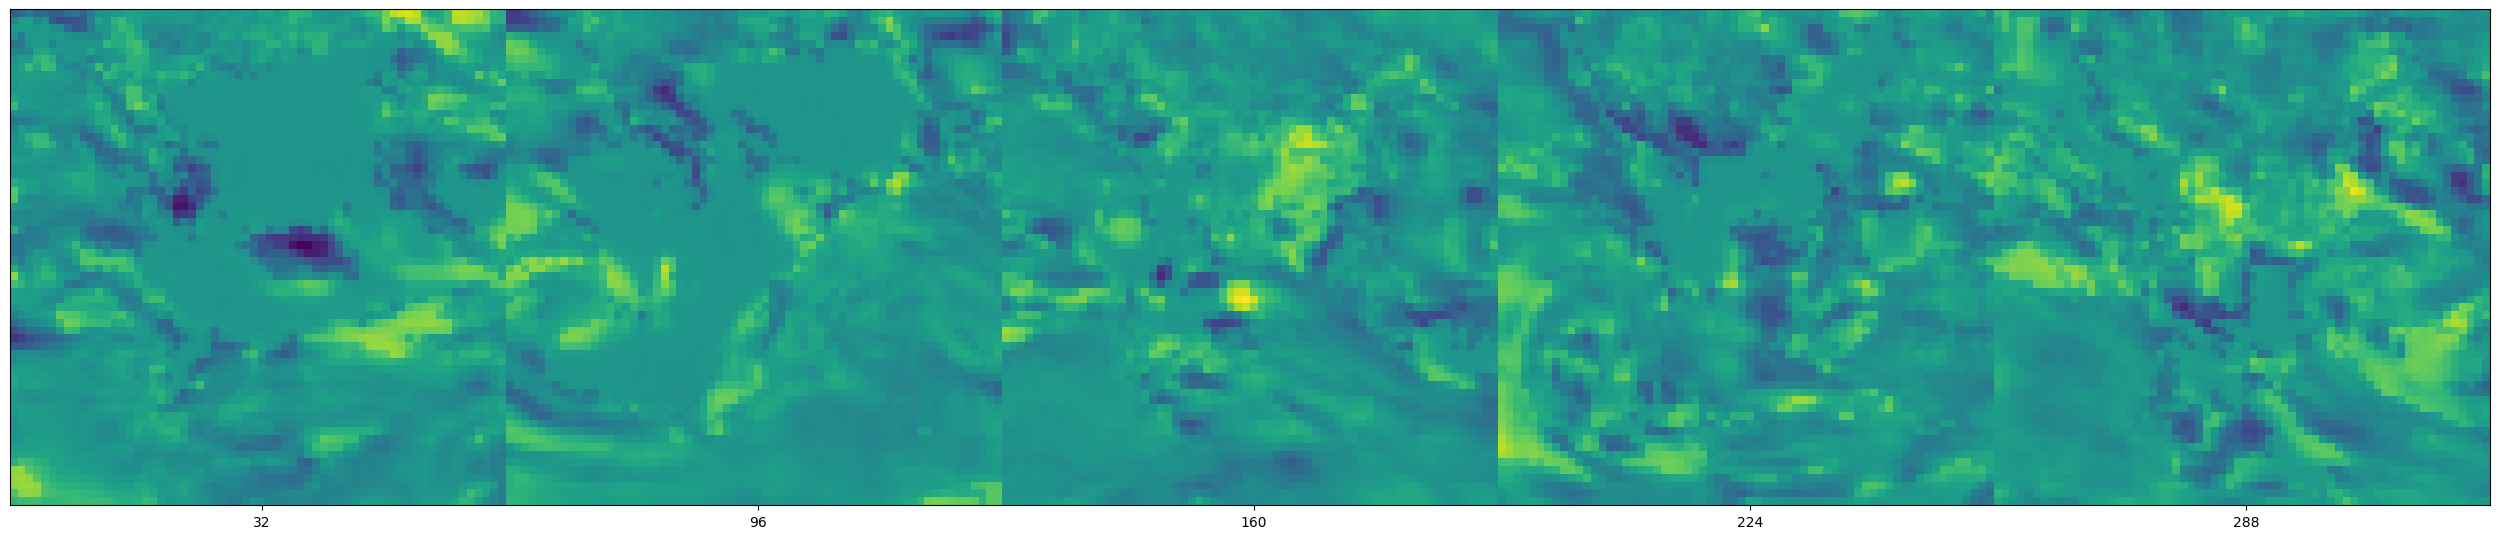

In [29]:
plot_images_no_lab(output_[:5]-label_[:5])

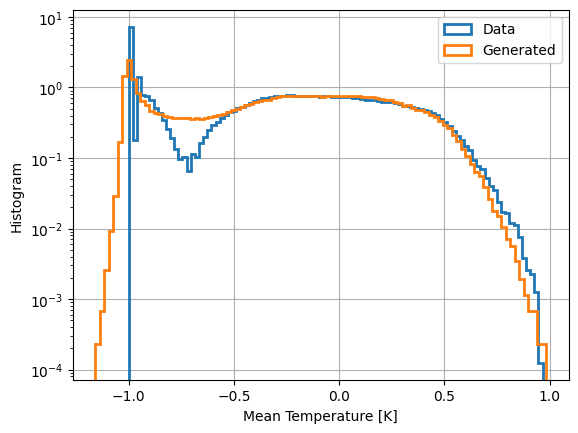

In [30]:
histograms(label_, output_)

In [31]:
def longitudinal_mean(original, generated, var="t"): 
    original = original.cpu().mean(dim=(0, 1, 3))
    generated = generated.cpu().mean(dim=(0, 1, 3))
    
    # Change the latitudes range to go from 0 to -63
    latitudes = range(-90, -26)  
    
    fig, ax = plt.subplots()
    ax.plot(latitudes, original, label='original')
    ax.plot(latitudes, generated, label='generated')
    ax.set_xlabel('Latitude')
    if var == "t":
        ax.set_ylabel('Temperature')
    else:
        ax.set_ylabel('Precipitation')
    ax.legend()
    plt.show()
    
    
def latitudinal_mean(original, generated, var="t"): 
    print(original.shape)
    original = original.cpu().mean(dim=(0, 1, 2))
    generated = generated.cpu().mean(dim=(0, 1, 2))
    print(original.shape)
    
    # Change the latitudes range to go from 0 to -63
    latitudes = range(0, -64, -1)  
    
    fig, ax = plt.subplots()
    ax.plot(latitudes, original, label='original')
    ax.plot(latitudes, generated, label='generated')
    ax.set_xlabel('Longitude')
    if var == "t":
        ax.set_ylabel('Temperature')
    else:
        ax.set_ylabel('Precipitation')
    ax.legend()
    plt.show()


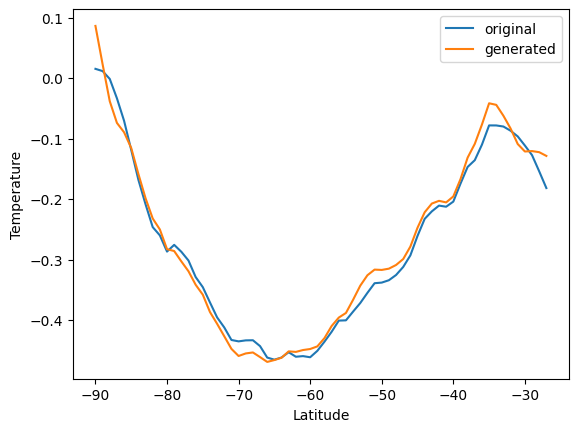

In [32]:
longitudinal_mean(label_, output_)

torch.Size([100, 1, 64, 64])
torch.Size([64])


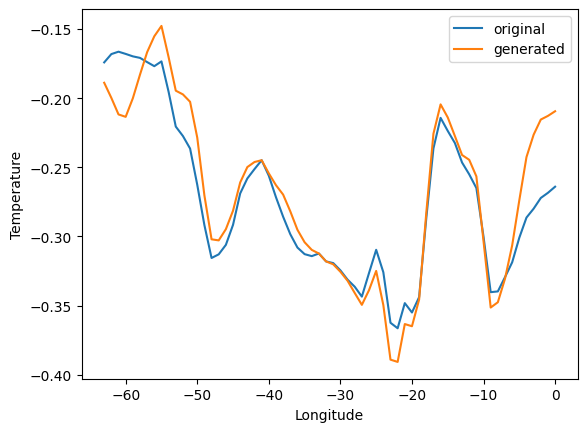

In [33]:
latitudinal_mean(label_, output_)

In [34]:
import numpy as np
import math

def calculate_ssim(img1, img2):
    # Compute mean values
    mean1 = np.mean(img1)
    mean2 = np.mean(img2)

    # Compute variances
    var1 = np.var(img1)
    var2 = np.var(img2)

    # Compute covariance
    cov = np.cov(img1.flatten(), img2.flatten())[0, 1]

    # Constants for SSIM calculation
    c1 = (0.01 * 255) ** 2
    c2 = (0.03 * 255) ** 2

    # Compute SSIM
    numerator = (2 * mean1 * mean2 + c1) * (2 * cov + c2)
    denominator = (mean1 ** 2 + mean2 ** 2 + c1) * (var1 + var2 + c2)
    ssim = numerator / denominator

    return ssim

# Assuming output_ and label_ are NumPy arrays representing the images
output_images = output_[0].squeeze().detach().numpy()
label_images = label_[0].squeeze().detach().numpy()

ssim_scores = []
for i in range(len(output_images)):
    output_image = output_images[i].squeeze()  # Remove the channel dimension if present
    label_image = label_images[i].squeeze()  # Remove the channel dimension if present

    ssim = calculate_ssim(output_image, label_image)
    ssim_scores.append(ssim)

average_ssim = np.mean(ssim_scores)

print("Average SSIM:", average_ssim)


Average SSIM: 0.9975091562449362
